## A/B Testing
Hypothesis testing for comparing the behaviour of two independent groups 

In [30]:
# importing all the libs we will need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import fisher_exact, norm
from statsmodels.graphics.gofplots import qqplot

Let's ingest the data and start doing some transformations to help us later on

In [31]:
# ingesting the data that is available in csv format

df = pd.read_csv(r"C:\Users\artur\ab_test\cookie_cats.csv")

# changing the text in the retention_7 column to a string format for visualization and interpretation purposes

df["retention_7"] = np.where(df["retention_7"]==True, "Yes", "No")

# First tests: Difference of Means
Here we are checking if the difference between the means of rounds played by the users within each version group (Gate 30 and Gate 40) is statistically significant.

Let's take a deeper dive into the feature that states how many rounds (levels) a user played. As we can see, that are a lot of outliers, resulting in a very skewed distribution, after all the 99th percentile is 493 and the max value is 49854.

In [12]:
df["sum_gamerounds"].describe(percentiles=[0.25,0.50,0.75,0.95,0.96,0.97,0.98,0.99])

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
95%        221.000000
96%        254.000000
97%        299.000000
98%        364.000000
99%        493.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

Taking the value of 500 rounds (close to the 99th percentile) let's check how this threshold separates our data

In [3]:
threshold = 500
a = len(df.loc[df["sum_gamerounds"] >= threshold])
b = len(df.loc[df["sum_gamerounds"] < threshold])
print(f"Number of players with number of rounds played equal or higher than {threshold}: {a} - {round((a/len(df))*100, 2)}% of the total players")
print(f"Number of players with number of rounds played lower than {threshold}: {b} - {round((b/len(df))*100, 2)}% of the total players")

Number of players with number of rounds played equal or higher than 500: 860 - 0.95% of the total players
Number of players with number of rounds played lower than 500: 89329 - 99.05% of the total players


As we can see above, less than 1% of the users played more than 500 rounds. Since our first hypothesis test will be considering the difference of means, let's remove these values that are way to high in comparison with the bigger mass of users. Also, below, we can see that these users that played a lot of rounds are well distributed between the game versions: for the hardcore players the level-position of the gate does not make much difference.

Also we are plotting a box-plot visual to check, after removing the users that played more than 500 levels, the distribution of the 'sum_gamerounds'.

In [5]:
df.loc[df["sum_gamerounds"] >= threshold].groupby(["version"])['userid'].count()

version
gate_30    428
gate_40    432
Name: userid, dtype: int64

[]

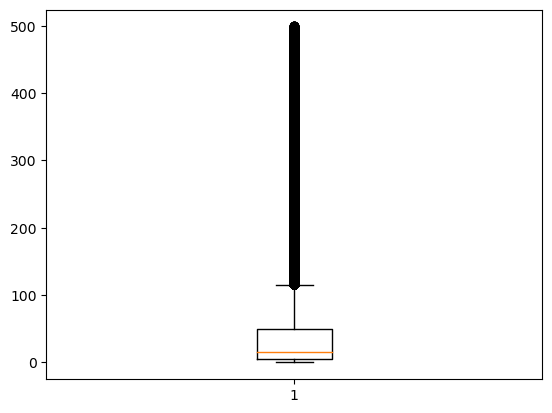

In [119]:
plt.boxplot(df.loc[df["sum_gamerounds"] < 500]["sum_gamerounds"])
plt.plot()

In [3]:
df_mean = df.loc[df["sum_gamerounds"] < 500]

Let's also check if there is any user that just downloaded the game but did not play a single level. We can see below that 4.43% of the players (remember that now we removed the outliers) have not played a single level. Since we want to check the hypothesis of users that actually interacted with the game, these users will be removed from the analysis.

In [7]:
z = len(df_mean.loc[df_mean["sum_gamerounds"] < 1])
print(f"Number of players that have not even played the game: {z} - {round((z/len(df))*100, 2)}% of the total players")

Number of players that have not even played the game: 3994 - 4.43% of the total players


In [4]:
df_mean = df_mean.loc[df_mean["sum_gamerounds"] > 0]

One important thing we need to address is the distribution of the variable 'sum_gamerounds' within each version if the game. If their distribution is approximately normal, we can simply use a t-test, for example, or even a z-test if we have a large sample size. However, if their distributions are far from normal (highly skewed, for example), the test approach needs to be different. Let's check, below, using a qq-plot and a histogram, if the distributions are approximately normal.

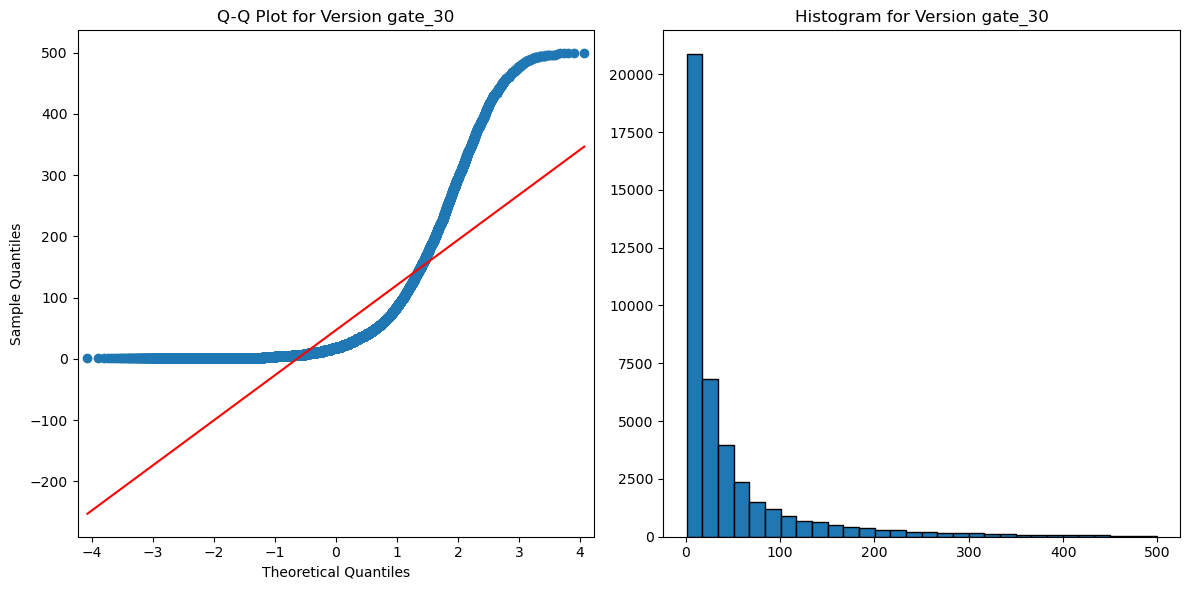

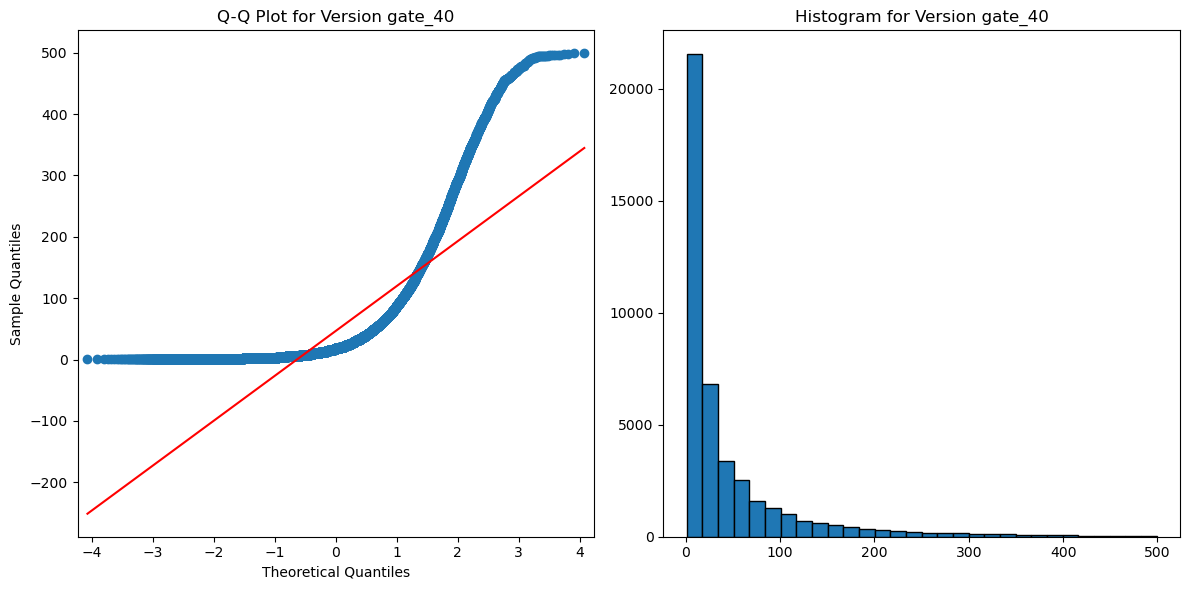

In [9]:
for v in df_mean["version"].unique():
    data = df_mean.loc[df_mean["version"] == v, "sum_gamerounds"]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    qqplot(data, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot for Version {v}')

    plt.subplot(1, 2, 2)
    plt.hist(data, bins=30, edgecolor='black')
    plt.title(f'Histogram for Version {v}')

    plt.tight_layout()
    plt.show()

As we can see above, the distributions are highly skewed, with a lot of higher numbers (right skew).

With this, we need to adopt other types of hypothesis testing, such as applying t-test for difference of means considering log-transformed data (technique adopted to approx. our data to a normal behaviour) and applying the non-parametric Mann-Whitney U test.

We will proceed with both to check for hypothesis. Also, in the case of the t-test applied to log-transformed data, we will consider from the start that the variances of each group are not equal for the sake of simplicity.

Also below we can see that the mean value of 'sum_gamerounds' for the version of Gate 30 is 46.898 levels, and for the version of Gate 40 is 46.730 levels, which are seemingly very similar.

In [30]:
df_mean["version"].value_counts()

gate_40    43000
gate_30    42335
Name: version, dtype: int64

In [31]:
mean_30 = np.mean(df_mean.loc[df_mean["version"] == 'gate_30']["sum_gamerounds"].values)
mean_40 = np.mean(df_mean.loc[df_mean["version"] == 'gate_40']["sum_gamerounds"].values)

print(f"Mean of sum of round played for players in the Gate 30 group: {mean_30}")
print(f"Mean of sum of round played for players in the Gate 40 group: {mean_40}")

Mean of sum of round played for players in the Gate 30 group: 46.89812212117633
Mean of sum of round played for players in the Gate 40 group: 46.730186046511626


## Hypothesis
We now need to state our hypothesis in order to proceed. We would like to know if changing the gate that charges users to move faster in the game from level 30 to level 40 increases the number of round the users play, retaining them within the game. We are assuming that the values sampled are independent from each other and were obtained through a simple random sampling process.

Our null hypothesis is that the means of rounds played by the users in both version groups (Gate 30 and Gate 40) are statistically the same, therefore their difference equals 0. And our alternate hypothesis is that the means are statistically different according to a confidence level.

## H0: μ(40) - μ(30) = 0
## H1: μ(40) - μ(30) != 0

We are proceeding using a confidence level of 95%, therefore our α = 0.05, which are our chances of commiting a type I error: Rejecting null when null is true. We are doing a two-sided test here.

The function below performs two tests which are appropriate for the situation we have at hand: a highly skewed dataset. We are performing a t-test with log-transformed data and the non-parametric Mann-Whitney U test. These two are common approaches for skewed datasets that deviate strongly from normality.

If our p-value is lower than 0.05, we have strong evidences that our null hypothesis is false and, therefore, the means are potentially different from each other, in our case with a 95% confidence.

In [9]:
def apply_mean_tests(g1, g2, alt='two-sided'):

    t_statistic, p_value_ttest = stats.ttest_ind(np.log(g1), np.log(g2), equal_var=False, alternative=alt)

    print(f"p-value for t-test applied to log transformed data: {p_value_ttest}")
    if p_value_ttest < 0.05:
        print(r"H0 rejected: there is significant difference between the means with a 95% confidence considering t-test with log transformed data")
    else:
        print(r"H0 NOT rejected: there is NO significant difference between the means with a 95% confidence considering t-test with log transformed data")
    
    print("==============================")

    mw_statistic, p_value_mw = stats.mannwhitneyu(g1, g2, )

    print(f"p-value for Mann-Whitney U test: {p_value_mw}")
    if p_value_ttest < 0.05:
        print(r"H0 rejected: there is significant difference between the means with a 95% confidence considering Mann-Whitney U test")
    else:
        print(r"H0 NOT rejected: there is NO significant difference between the means with a 95% confidence considering Mann-Whitney U test")


As we can see below, no significant difference between the means was detected according to our confidence level, in both tests this conclusion was made.

In [33]:
apply_mean_tests(df_mean.loc[df_mean["version"] == 'gate_30']["sum_gamerounds"].values, 
                 df_mean.loc[df_mean["version"] == 'gate_40']["sum_gamerounds"].values)

p-value for t-test applied to log transformed data: 0.13739395470526766
H0 NOT rejected: there is NO significant difference between the means with a 95% confidence considering t-test with log transformed data
p-value for Mann-Whitney U test: 0.11411420078473904
H0 NOT rejected: there is NO significant difference between the means with a 95% confidence considering Mann-Whitney U test


However, another interpretation of the problem can be made. Users that haven't reached level 30 have not felt the difference of the gate change in any way. Changing the level-position of the gate, for these users, does not make any difference!

So, another approach, considering this, can be made: If we test the means considering only players that reached, at least, level 30.

Below, when we do this, another conclusion is made: There is a significant difference between the means! Both α were less than 0.05.

In [5]:
df_mean = df_mean.loc[df_mean["sum_gamerounds"] > 29]

apply_mean_tests(df_mean.loc[df_mean["version"] == 'gate_30']["sum_gamerounds"].values, 
                 df_mean.loc[df_mean["version"] == 'gate_40']["sum_gamerounds"].values)

p-value for t-test applied to log transformed data: 0.0015090587655257925
H0 rejected: there is significant difference between the means with a 95% confidence considering t-test with log transformed data
p-value for Mann-Whitney U test: 7.217828507999074e-05
H0 rejected: there is significant difference between the means with a 95% confidence considering Mann-Whitney U test


And as we can see below, the mean number of rounds for users that were in the version Gate 40 was higher than version Gate 30.

Also, other tests were done, considering now the alternative hypothesis that:

## H1: μ(40) - μ(30) > 0

And we one more time see that indeed there is a difference between the means and that changing the gate from level 30 to level 40 increased the mean number of rounds played with a confidence level of 95% and the approach to consider only players that have actually had contact with the changes (players that reached at least level 30).

In [6]:
mean_30 = np.mean(df_mean.loc[df_mean["version"] == 'gate_30']["sum_gamerounds"].values)
mean_40 = np.mean(df_mean.loc[df_mean["version"] == 'gate_40']["sum_gamerounds"].values)

print(f"Mean of sum of round played for players in the Gate 30 group: {mean_30}")
print(f"Mean of sum of round played for players in the Gate 40 group: {mean_40}")

Mean of sum of round played for players in the Gate 30 group: 106.2326842494454
Mean of sum of round played for players in the Gate 40 group: 107.7578641616711


In [10]:
apply_mean_tests(df_mean.loc[df_mean["version"] == 'gate_30']["sum_gamerounds"].values, 
                 df_mean.loc[df_mean["version"] == 'gate_40']["sum_gamerounds"].values,
                 alt='less')

p-value for t-test applied to log transformed data: 0.0007545293827628962
H0 rejected: there is significant difference between the means with a 95% confidence considering t-test with log transformed data
p-value for Mann-Whitney U test: 7.217828507999074e-05
H0 rejected: there is significant difference between the means with a 95% confidence considering Mann-Whitney U test


# Second tests: Difference of Proportions
Here we are checking if the retention of users, considering if they returned to the game 7 days after installing if, is significant.

If a user has "Yes" in the column 'retention_7', it means that they returned to the game 7 days after installing it, and therefore we consider that the user was retained.

First, let's remove the players that have not felt the impact of the change of the gate's position (users that have not reached ate least level 30). Also, since we are not dealing with the number of rounds played, we are not removing the players that played a lot of rounds (more than the threshold of 500 previously set). Also, as seen below, we can still see users that played more than 500 rounds but still were not retained 7 days after installing the game. 

In [32]:
df_prop = df[["userid", "sum_gamerounds", "version", "retention_7"]]

In [33]:
df_prop.loc[(df_prop["sum_gamerounds"] >= 500)].groupby('retention_7').agg(N_users=('userid', 'count'),
                                                                           Max_rounds=('sum_gamerounds', np.max)).reset_index()

,retention_7,N_users,Max_rounds
0,No,38,2640
1,Yes,822,49854


In [34]:
df_prop = df_prop.loc[(df_prop["sum_gamerounds"] > 29)]

In the next three cells, some previous exploration of the data was made.

From the spot we can see that the proportions of users retained are very close:

Gate 30 = 43.88%

Gate 40 = 43.00%

Now we need to check if indeed they are not different of eachother.

In [24]:
df_prop_grouped1 = df_prop.groupby(["version", "retention_7"]).agg(total_samples=("userid", 'count')).reset_index()
df_prop_grouped1['total_version_samples'] = df_prop_grouped1.groupby('version')['total_samples'].transform('sum')
df_prop_grouped1

,version,retention_7,total_samples,total_version_samples
0,gate_30,No,9348,16656
1,gate_30,Yes,7308,16656
2,gate_40,No,9469,16613
3,gate_40,Yes,7144,16613


In [25]:
total_30 = len(df_prop.loc[(df_prop["version"]=="gate_30")])
total_40 = len(df_prop.loc[(df_prop["version"]=="gate_40")])
prop_30 = df_prop_grouped1.loc[(df_prop_grouped1["retention_7"]=="Yes") & (df_prop_grouped1["version"]=="gate_30")]["total_samples"].values[0] / total_30
prop_40 = df_prop_grouped1.loc[(df_prop_grouped1["retention_7"]=="Yes") & (df_prop_grouped1["version"]=="gate_40")]["total_samples"].values[0] / total_40

In [26]:
print(f"Proportion of players retained after 7 days in the Gate 30 Version: {round(prop_30*100, 2)}")
print(f"Proportion of players retained after 7 days in the Gate 40 Version: {round(prop_40*100, 2)}")

Proportion of players retained after 7 days in the Gate 30 Version: 43.88
Proportion of players retained after 7 days in the Gate 40 Version: 43.0


Let's also check if we have enough samples in each group to perform a z-test of proportions.

We first calculate the pooled proportion, p_hat, and then check for each sample if n * p_hat >= 10 and n * (1-p_hat) >= 10.

And they are.

In [27]:
p_hat = (total_30*prop_30 + total_40*prop_40) / (total_30 + total_40)
print(f"For Gate 30 Version: p(n)={p_hat*total_30}, 1-p(n)={(1-p_hat)*total_30}")
print(f"For Gate 30 Version: p(n)={p_hat*total_40}, 1-p(n)={(1-p_hat)*total_40}")

For Gate 30 Version: p(n)=7235.339565361147, 1-p(n)=9420.660434638854
For Gate 30 Version: p(n)=7216.660434638853, 1-p(n)=9396.339565361148


## Hypothesis
We now need to state our hypothesis in order to proceed. We would like to know if changing the gate that charges users to move faster in the game from level 30 to level 40 changes the retention of users 7 days after installing the game. We are assuming that the values sampled are independent from each other and were obtained through a simple random sampling process.

Our null hypothesis is that the proportions of players retained 7 days after installing the game in the Gate 30 version and in the Gate 40 version are statistically the same, therefore their difference equals 0. And our alternate hypothesis is that the proportions are statistically different according to a confidence level.

## H0: p(40) - p(30) = 0
## H1: p(40) - p(30) != 0

We are proceeding using a confidence level of 95%, therefore our α = 0.05, which are our chances of commiting a type I error: Rejecting null when null is true. We are doing a two-sided test here.

We are going to apply two tests: A z-test for proportions and a Fisher Exact test. Since we have very large samples, the z-test would be enough, but for studying purposes we are doing Fisher's test too.


In [28]:
def apply_prop_tests(true1, true2, n1, n2):
    
    # Fisher's Exact Test
    contingency_table = np.array([
        [true1, n1 - true1],
        [true2, n2 - true2]
    ])

    odds_ratio, p_value_fisher = fisher_exact(contingency_table)

    # Z-test for Proportions
    p1 = true1 / n1
    p2 = true2 / n2

    p_pool = (true1 + true2) / (n1 + n2)

    se = np.sqrt(p_pool * (1 - p_pool) * (1 / n1 + 1 / n2))

    z_score = (p1 - p2) / se

    p_value_z = 2 * (1 - norm.cdf(np.abs(z_score)))

    print(f"Proportion of users retained after 7 days in the Gate 30 version: {round(p1*100, 2)}")
    print(f"Proportion of users retained after 7 days in the Gate 40 version: {round(p2*100, 2)}")
    
    print("==============================")
    
    print(f"p-value for Fisher's exact test: {p_value_fisher}")
    if p_value_fisher < 0.05:
        print(r"H0 rejected: there is significant difference between the proportions with a 95% confidence considering Fisher's exact test")
    else:
        print(r"H0 NOT rejected: there is NO significant difference between the proportions with a 95% confidence considering Fisher's exact test")
    
    print("==============================")

    print(f"p-value for Z-test: {p_value_z}")
    if p_value_z < 0.05:
        print(r"H0 rejected: there is significant difference between the proportions with a 95% confidence considering Z-test")
    else:
        print(r"H0 NOT rejected: there is NO significant difference between the proportions with a 95% confidence considering Z-test")


When we apply the tests, both of them state that, with 95% confidence, there is no statistical difference between the proportions of users retained 7 deys after installing the game, remembering that we considered only the players that had contact with the changes, which are the users that played at least 30 rounds.

In [29]:
apply_prop_tests(true1 = df_prop_grouped1.loc[(df_prop_grouped1["retention_7"]=="Yes") & (df_prop_grouped1["version"]=="gate_30")]["total_samples"].values[0],
                 true2 = df_prop_grouped1.loc[(df_prop_grouped1["retention_7"]=="Yes") & (df_prop_grouped1["version"]=="gate_40")]["total_samples"].values[0],
                 n1 = total_30,
                 n2 = total_40)

Proportion of users retained after 7 days in the Gate 30 version: 43.88
Proportion of users retained after 7 days in the Gate 40 version: 43.0
p-value for Fisher's exact test: 0.10876756007199474
H0 NOT rejected: there is NO significant difference between the proportions with a 95% confidence considering Fisher's exact test
p-value for Z-test: 0.10797874787534667
H0 NOT rejected: there is NO significant difference between the proportions with a 95% confidence considering Z-test


## Conclusions
When considering only the users that played 30 rounds or more, having contact with the changes made with the gates' positions, and not considering, for the difference of means, users that played more rounds than the 99th percentile of the rounds played by each player (being therefore considered as outliers that could potentially wrongly deviate the results since they are players that played so much that the gate's position does not make any difference whatsoever):

We conclude that the mean number of rounds played increased when we changed the gate's position from level 30 to level 40. However, the retention of players in the 7th day after the game installation did not suffer any significant changes, all considering a 95% level of confidence.

This could mean that indeed the players played more rounds when we changed the gate's position from gate 30 to gate 40, however these more extense game sessions occured within the first week and before the last day of the said week, which could indicate that only changing the gate's position is not enough to increase user retention.